# $\chi^2$ Investigations

In this notebook we first investigate how the `absolute_simga` parameter of `curve_fit` can affect the inferred uncertainty on the data.

To this end, we simulate many dataset using a normal distribution:

$$ y\sim \mathcal{N}(\mu, \sigma_y)$$

With $\mu$ the true position as given by our model and $\sigma_y$ the uncertainty (standard error) of the data $y$.

First we define our model:

In [2]:
# basic imports
import scipy.stats
from scipy.optimize import curve_fit
from pylab import * #lazy

# let's define our model
np.random.seed(10) # fix seed to compare results

# we fix the true values of the parameters
a_true = 2
b_true = 3

# we fix the range of of the independent variable (say, time)
xmin = 0.1
xmax = 10

def linear_model(x, a, b):
	'''
	a line
	'''
	return a + x*b

This function simulates data. We may assume that the uncertainty on $y$ is a fixed fraction of the true value.

In [3]:
def sim_data(x, fractional_uncertainty=0.2):

	# find the model prediction
	y_true = model(x, a_true, b_true)

	# find the true uncertainty on the observations
	y_unc_true = np.abs(y_true)*fractional_uncertainty

	# generate data for a normal distribution
	y_sample = np.random.normal(y_true, y_unc_true, size=len(x))

	return y_sample, y_unc_true


_the cell below allows you to toggle between models (these will be added later)_

In [4]:
# lets pick one model
model = linear_model
#model = non_linear_model # you might add this later



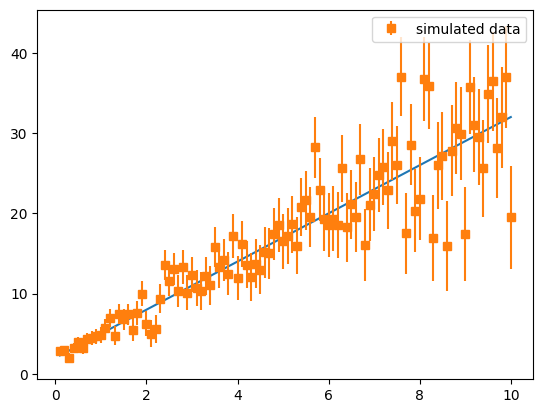

if you think this looks weird, it helps to look in log-space


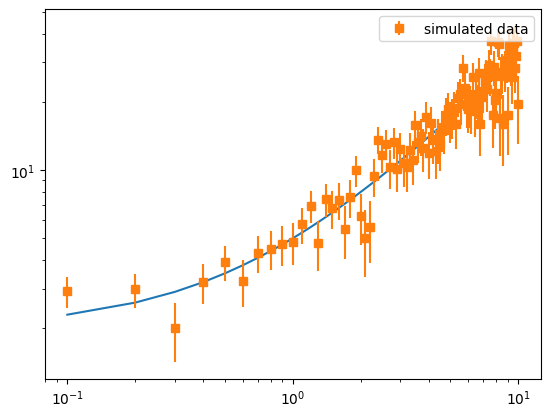

In [5]:
	# plot the simulation results
xx = np.linspace(xmin, xmax, 100)
data_example = sim_data(xx)

plt.clf()
plt.plot(xx, model(xx, a_true, b_true))
plt.errorbar(xx, data_example[0],data_example[1], fmt='s', label='simulated data')
plt.legend()
plt.pause(0.1)
print('if you think this looks weird, it helps to look in log-space')

plt.clf()
plt.plot(xx, model(xx, a_true, b_true))
plt.errorbar(xx, data_example[0],data_example[1], fmt='s', label='simulated data')
plt.legend()
plt.yscale('log')
plt.xscale('log')

## Part 1: $\chi^2$ rescaling of `curve_fit`

Make 5000 simulation of a dataset with N=3 points. Of each simulation, find the standard error on the slope ($\sigma_{b}$) of the best-fit line using `curve_fit` with `absolute_sigma=False` (the default). In this setting the uncertainties are rescaled using the $\chi^2$ of the best-fit parameters.

- Plot a distribution of the 5000 $\chi^2$ and compare to the theoretical value (see `scipy.stats.chi2`).

- Compare the distribution of $\sigma_{b}$ with the "correct" value. How often is confidence interval with $\chi^2$-rescaling a factor 2 larger compared to the correct value?

- Repeat the last step with $N=10$ datapoints.

100%|██████████| 5000/5000 [00:04<00:00, 1212.69it/s]


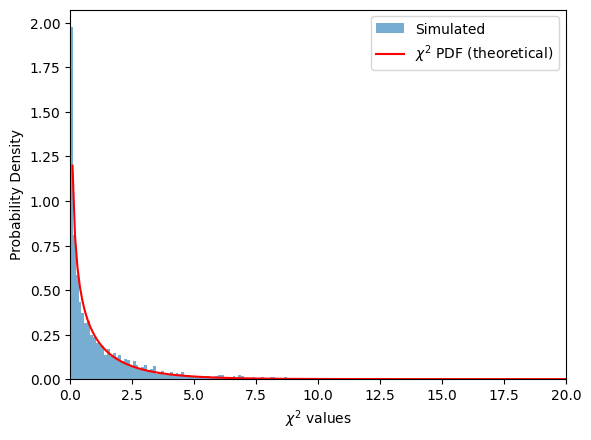

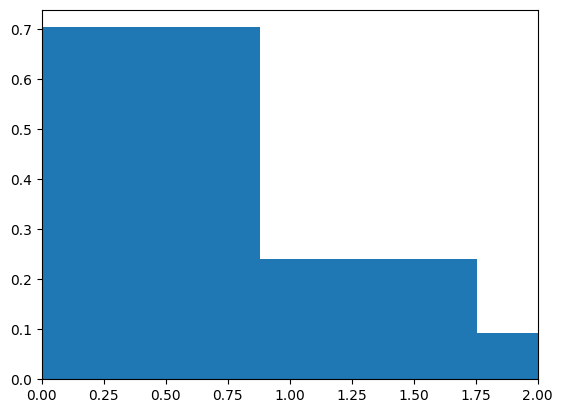

In [104]:
import scipy
from tqdm import tqdm

N = 3
dof = N - 2
a_values = []
b_values = []
chi2_values = []
sigma_values = []
for i in tqdm(range(5000)):
	x = np.random.uniform(xmin, xmax, N)
	y_data, y_err = sim_data(x)
	popt, pcov = scipy.optimize.curve_fit(linear_model, x, y_data, absolute_sigma = False)
	
	y_model = linear_model(x, popt[0], popt[1])
	chi2 = np.sum(((y_data - y_model) / y_err) ** 2)
	sigma = np.sqrt(np.diag(pcov))[1]
	sigma_values.append(sigma)
	chi2_values.append(chi2)
	# a_values.append(popt[0]), b_values.append(popt[1])

plt.figure()
plt.hist(chi2_values, density = True, bins=500, alpha=0.6, label='Simulated')

# Plot the theoretical chi-square distribution
x_range = np.linspace(0, 50, 500)
chi2_pdf = scipy.stats.chi2.pdf(x_range, df=dof)
plt.plot(x_range, chi2_pdf, label=r'$\chi^2$ PDF (theoretical)', color='red')

plt.xlabel(r'$\chi^2$ values')
plt.xlim(0, 20)
plt.ylabel('Probability Density')
plt.legend()
plt.show()
plt.figure()
plt.hist(sigma_values, density = True, bins = 100)
plt.xlim(0, 2)
plt.show()

## Part 2: Bootstrap and non-linear least-squares

First let's check that bootstrap works for our linear model. Let's do a non-parametric bootstap:

-  simulate _a single_ dataset with $N=400$ points
- Draw $B=20000$ bootstrap samples.
- Compare the bootstrapped distribution of the parameter $b$ with the normal distribution, $\mathcal{N}(0,\sigma_b)$, predicted by the least-squares fit.

You should find good agreement.

In [ ]:
N = 400
x = np.linspace(0, 100, N)

The documentation of `curve_fit` says:  
>Note that the relationship between cov and parameter error estimates is derived based on a linear approximation to the model function around the optimum [1]. When this approximation becomes inaccurate, cov may not provide an accurate measure of uncertainty.

But how bad can it be? Let's check. Again we use only two parameters $a$ and $b$.  

We know that the bootstrap will give a more correct answer than least-squares, so we can use this to check the preformance of `curve_fit` confidence intervals.

- dream-up a non-linear model that combines $a$ and $b$, add this above and set `model = non_linear_model`
- Redo comparison of the bootstrap confidence interval with least-squares normal distribution.
 - do you see any difference?
 - Does least-squares aways under/over predict the uncertainty?